In [ ]:
import getpass

github_username = "AnFreTh"
repo_name = "NAMgcv"
branch_name = "dev_bnam_jax"
personal_access_token = getpass.getpass("Enter your GitHub personal access token: ")

In [ ]:
clone_url = (
    f"https://"
    f"{github_username}:{personal_access_token}"
    f"@github.com/"
    f"{github_username}/"
    f"{repo_name}.git"
)
!git clone -b $branch_name $clone_url

In [ ]:
cd $repo_name
!pip install -r requirements.txt

In [2]:
from typing import Tuple, Dict, Any

import jax.nn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns

from namgcv.basemodels.bnam import BayesianNAM
from namgcv.configs.bayesian_nam_config import DefaultBayesianNAMConfig
from namgcv.configs.bayesian_nn_config import DefaultBayesianNNConfig

C:\ProgramData\miniconda3\envs\NAMgcv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
GREEN_RGB_COLORS = [
    '#004c00',  # '#004e00', '#005000', '#005100', '#005300',
    # '#005500', # '#005700', '#005900', '#005a00', '#005c00',
    '#005e00',  # '#006000', '#006200', '#006300', '#006500',
    # '#006700', # '#006900', '#006b00', '#006c00', '#006e00',
    '#007000',  # '#007200', '#007400', '#007500', '#007700',
    # '#007900', # '#007b00', '#007d00', '#007e00', '#008000',
    '#008200',  # '#008400', '#008600', '#008800', '#008900',
    # '#008b00', # '#008d00', '#008f00', '#009100', '#009200',
    '#009400',  # '#009600', '#009800', '#009a00', '#009b00',
    # '#009d00', # '#009f00', '#00a100', '#00a300', '#00a400',
    '#00a600',  # '#00a800', '#00aa00', '#00ac00', '#00ad00',
    # '#00af00', # '#00b100', '#00b300', '#00b500', '#00b600',
    '#00b800',  # '#00ba00', '#00bc00', '#00be00', '#00bf00',
    # '#00c100', # '#00c300', '#00c500', '#00c700', '#00c800',
    '#00ca00',  # '#00cc00', '#00ce00', '#00d000', '#00d100',
    # '#00d300', # '#00d500', '#00d700', '#00d900', '#00da00',
    '#00dc00',  # '#00de00', '#00e000', '#00e200', '#00e300',
    # '#00e500', # '#00e700', '#00e900', '#00eb00', '#00ec00',
    '#00ee00',  # '#00f000', '#00f200', '#00f400', '#00f500',
    # '#00f700', # '#00f900', '#00fb00', '#00fd00', '#00ff00'
]

In [4]:
def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
):
    """
    Plots feature contributions for numerical, categorical, and interaction features.
    Now includes a separate heatmap panel for the uncertainty of interaction features.
    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features.
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features.
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of interaction features.
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names and values
            as numpy arrays of shape [num_samples, batch_size].
        target (jnp.ndarray):
            Target variable.
        aleatoric_uncertainty (Dict[str, jnp.ndarray]):
            Dictionary of aleatoric uncertainty estimates for each feature.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    # Plot numerical features
    if num_features:
        num_plots = len(num_features)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=2,
            figsize=(12*2, 6 * num_plots),
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(num_features.items()):
            # eu = np.std(np.mean(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(np.var(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(aleatoric_uncertainty[f"{feature_name}/{feature_name}_num_subnetwork_sigma"])

            feature_values = np.array(feature_array).flatten()  # Convert JAX array to NumPy

            # Shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]

            # [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)
            for j in [0, 1]:
                mean_param_contribution = mean_contribution_all_params[:, j]

                # Create vertical colored bars with color intensity based on density
                sorted_idx = np.argsort(feature_values)
                feature_values_sorted = feature_values[sorted_idx]

                mean_param_contribution_sorted = mean_param_contribution[sorted_idx]

                if j == 0:
                    if feature_name == "numerical_1":
                        true_effect = 8 * (feature_values_sorted - 0.5) ** 2
                    elif feature_name == "numerical_2":
                        true_effect = 1 / 10 * np.exp(-8 * feature_values_sorted + 4)
                    elif feature_name == "numerical_3":
                        true_effect = 5 * np.exp(-2 * (2 * feature_values_sorted - 1) ** 2)
                    elif feature_name == "numerical_4":
                        true_effect = np.zeros_like(feature_values_sorted)
                else:
                    if feature_name == "numerical_1":
                        true_effect = feature_values_sorted
                    elif feature_name == "numerical_2":
                        true_effect = feature_values_sorted
                    elif feature_name == "numerical_3":
                        true_effect = feature_values_sorted
                    elif feature_name == "numerical_4":
                        true_effect = feature_values_sorted

                    mean_param_contribution_sorted = (
                        jax.nn.softplus(mean_param_contribution_sorted)
                    )

                # Plot the centered partial contributions.
                sns.lineplot(
                    x=feature_values_sorted,
                    y=mean_param_contribution_sorted,
                    color=GREEN_RGB_COLORS[0],
                    label="Mean Output Parameter Contribution",
                    ax=ax[i, j]
                )

                # Proper min–max scaling of the true effect onto [lower, upper]
                lower_sorted, upper_sorted = (mean_param_contribution_sorted.min(),
                                              mean_param_contribution_sorted.max())
                te_min, te_max = true_effect.min(), true_effect.max()
                true_effect_norm = (true_effect - te_min) / (te_max - te_min)  # now in [0,1]
                true_effect = true_effect_norm * (upper_sorted - lower_sorted) + lower_sorted

                sns.lineplot(
                    x=feature_values_sorted,
                    y=true_effect,
                    color="black",
                    linestyle='dashed',
                    label="True effect",
                    ax=ax[i,j],
                )

                uncertainty = np.std(submodel_contributions[feature_name][:, :, j], axis=0)[sorted_idx]
                ax[i,j].fill_between(
                    feature_values_sorted,
                    mean_param_contribution_sorted - 1.96 * uncertainty,
                    mean_param_contribution_sorted + 1.96 * uncertainty,
                    alpha=0.3,
                    color=GREEN_RGB_COLORS[-5],
                    label="Epistemic Uncertainty - 95% Interval"
                )

                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                norm_counts = counts / counts.max()
                fixed_height = ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0]
                for k in range(num_bins):
                    ax[i,j].bar(
                        bin_edges[k],
                        height=fixed_height,
                        bottom=ax[i,j].get_ylim()[0],
                        width=bin_edges[k + 1] - bin_edges[k],
                        color=plt.cm.Blues(norm_counts[k]),
                        alpha=0.3
                    )

                ax[i,j].set_xlabel(f"{feature_name}", fontsize=12)
                ax[i,j].set_ylabel("Feature Contribution", fontsize=12)
                ax[i,j].set_title(f"Feature Contribution for {feature_name}", fontsize=12)
                ax[i,j].legend(loc='best', fontsize=12, frameon=False)
                ax[i,j].grid(True)

        plt.tight_layout()
        plt.savefig('num_feature_contributions.png')
        plt.show()

In [5]:

def plot_synthetic_data(
        true_effects: dict,
):
    """
    Function to plot the synthetic data generated for testing the BayesianNAM model.

    Parameters
    ----------
    true_effects: dict containing the true effects of the features.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})

    single_true_effects = {
        feature_name: feature_value for feature_name, feature_value in true_effects.items()
        if ":" not in feature_name
    }
    if single_true_effects:
        fig, axes = plt.subplots(
            nrows=len(single_true_effects),
            ncols=2,
            figsize=(12, 6 * len(single_true_effects))
        )
        for i, feature_name in enumerate(single_true_effects.keys()):
            x_vals = single_true_effects[feature_name]["feature"]
            y_mean = single_true_effects[feature_name]["response"]

            sort_idx = np.argsort(x_vals)
            x_sorted = x_vals[sort_idx]
            y_sorted = y_mean[sort_idx]

            # Plot noise intervals.
            if not isinstance(true_effects[feature_name]["noise_parameters"]["scale"], np.ndarray):
                true_effects[feature_name]["noise_parameters"]["scale"] = (
                        np.ones(len(x_sorted)) * true_effects[feature_name]["noise_parameters"]["scale"]
                )

            for ci_multiplier, alpha in zip([3, 2, 1], [0.2, 0.4, 0.8]):
                axes[i,0].fill_between(
                    x_sorted,
                    y_sorted - ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    y_sorted + ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color=GREEN_RGB_COLORS[-1],
                    alpha=alpha
                )
                # Plot outlines for the filled areas.
                axes[i,0].plot(
                    x_sorted,
                    y_sorted - ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )
                axes[i,0].plot(
                    x_sorted,
                    y_sorted + ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )

            # Plot points.
            sns.scatterplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["noisy_response"][sort_idx],
                color=GREEN_RGB_COLORS[5],
                label="Noisy Response",
                ax=axes[i,0]
            )
            # Plot mean.
            sns.lineplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["response"][sort_idx],
                color="black",
                label="True Mean Marginal Effect",
                ax=axes[i,0],
            )
            axes[i,0].set_title(f"{feature_name} Effect", fontsize=14)
            axes[i,0].set_xlabel(f"{feature_name}", fontsize=12)
            axes[i,0].set_ylabel("Effect", fontsize=12)
            axes[i,0].legend()
            axes[i,0].grid(True)

            # Plot noise intervals.
            axes[i, 1].axhline(0, color='black', label="True Noise Mean")
            for ci_multiplier, alpha in zip([3, 2, 1], [0.2, 0.4, 0.8]):
                axes[i, 1].fill_between(
                    x_sorted,
                    -ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color=GREEN_RGB_COLORS[-1],
                    alpha=alpha
                )
                # Plot outlines for the filled areas.
                axes[i, 1].plot(
                    x_sorted,
                    -ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )
                axes[i, 1].plot(
                    x_sorted,
                    ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )

            # Plot points.
            sns.scatterplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["noise"][sort_idx],
                color=GREEN_RGB_COLORS[5],
                label="Sampled Noise",
                ax=axes[i,1]
            )

            axes[i,1].set_title(f"{feature_name} Noise Effect", fontsize=14)
            axes[i,1].set_xlabel(f"{feature_name}", fontsize=12)
            axes[i,1].set_ylabel("Effect", fontsize=12)
            axes[i,1].legend()
            axes[i,1].grid(True)

        plt.legend()
        plt.tight_layout()
        plt.show()

In [6]:

def get_synthetic_data(n_samples: int=500):
    """
    Function to generate synthetic data for testing the BayesianNAM model.
    Returns a pandas DataFrame containing the synthetic data.

    Args:
        n_samples (int): Number of samples to generate.

    Returns:
        pd.DataFrame: DataFrame containing the synthetic data.
    """

    # ------------------
    # Generate features.
    # ------------------
    np.random.seed(42)

    numerical_1 = np.random.uniform(low=-1, high=1, size=n_samples)
    numerical_2 = np.random.uniform(low=-1, high=1, size=n_samples)
    numerical_3 = np.random.uniform(low=-1, high=1, size=n_samples)
    numerical_4 = np.random.uniform(low=-1, high=1, size=n_samples)

    # categorical_1 = np.random.choice(a=['A', 'B', 'C'], size=n_samples)
    # categorical_2 = np.random.choice(a=['X', 'Y', 'Z'], size=n_samples)
    # encoder = OneHotEncoder()
    # cat_1_encoded = pd.DataFrame(
    #     encoder.fit_transform(categorical_1.reshape(-1, 1)).toarray(),
    #     columns=[f"Cat1_{cat}" for cat in encoder.categories_[0]]
    # )
    # cat_2_encoded = pd.DataFrame(
    #     encoder.fit_transform(categorical_2.reshape(-1, 1)).toarray(),
    #     columns=[f"Cat2_{cat}" for cat in encoder.categories_[0]]
    # )

    # Make the noise parameters dependent on the true effects.
    noise_parameters = {
        "numerical_1": {"loc": 0, "scale": np.abs(numerical_1), "size": n_samples},
        "numerical_2": {"loc": 0, "scale": np.abs(numerical_2), "size": n_samples},
        "numerical_3": {"loc": 0, "scale": np.abs(numerical_3), "size": n_samples},
        "numerical_4": {"loc": 0, "scale": np.abs(numerical_4), "size": n_samples},
    }

    noise = {
        "numerical_1": np.random.normal(**noise_parameters["numerical_1"]),
        "numerical_2": np.random.normal(**noise_parameters["numerical_2"]),
        "numerical_3": np.random.normal(**noise_parameters["numerical_3"]),
        "numerical_4": np.random.normal(**noise_parameters["numerical_4"]),
        # "categorical_1": np.random.choice(**noise_parameters["categorical_1"]),
        # "categorical_2": np.random.choice(**noise_parameters["categorical_2"])
        # "numerical_1:numerical_2": np.random.normal(**noise_parameters["numerical_1:numerical_2"])
    }

    true_effects = {
        "numerical_1": {
            "response": 8*(numerical_1)**2,
            "feature": numerical_1,
            'noise_parameters': noise_parameters["numerical_1"],
            'noise': noise["numerical_1"]
        },
        "numerical_2": {
            "response": np.exp(-numerical_2),
            "feature": numerical_2,
            'noise_parameters': noise_parameters["numerical_2"],
            'noise': noise["numerical_2"]
        },
        "numerical_3": {
            "response": np.exp((numerical_3)**2),
            "feature": numerical_3,
            'noise_parameters': noise_parameters["numerical_3"],
            'noise': noise["numerical_3"]
        },
        "numerical_4": {
            "response": np.zeros_like(numerical_4),
            "feature": numerical_4,
            'noise_parameters': noise_parameters["numerical_4"],
            'noise': noise["numerical_4"]
        },
        # "numerical_1:numerical_2": {
        #     "response": numerical_1 * numerical_2,
        #     "feature": np.stack([numerical_1, numerical_2], axis=-1),
        #     'noise_parameters': noise_parameters["numerical_1:numerical_2"],
        #     'noise': noise["numerical_1:numerical_2"]
        # }
    }

    # noise_parameters = {
    #     "numerical_1": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_2": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_3": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_4": {"loc": 0, "scale": 1, "size": n_samples},
    #     # "categorical_1": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    #     # "categorical_2": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    # }
    # noise_parameters["numerical_1:numerical_2"] = {
    #         "loc": (
    #                 noise_parameters["numerical_1"]["loc"] *
    #                 noise_parameters["numerical_2"]["loc"]
    #         ),
    #         "scale": np.sqrt(
    #             (
    #                 noise_parameters["numerical_1"]["loc"]**2 *
    #                 noise_parameters["numerical_2"]["loc"]**2
    #             ) + (
    #                 noise_parameters["numerical_1"]["loc"]**2 *
    #                 noise_parameters["numerical_2"]["scale"]**2
    #             ) + (
    #                 noise_parameters["numerical_2"]["loc"]**2 *
    #                 noise_parameters["numerical_1"]["scale"] ** 2
    #             ) + (
    #                 noise_parameters["numerical_1"]["scale"]**2 *
    #                 noise_parameters["numerical_2"]["scale"]**2
    #             )
    #         ),
    #         "size": n_samples
    #     }
    true_effects["numerical_1"]["noisy_response"] = (
            true_effects["numerical_1"]["response"] +
            true_effects["numerical_1"]["noise"]
    )
    true_effects["numerical_2"]["noisy_response"] = (
            true_effects["numerical_2"]["response"] +
            true_effects["numerical_2"]["noise"]
    )
    true_effects["numerical_3"]["noisy_response"] = (
            true_effects["numerical_3"]["response"] +
            true_effects["numerical_3"]["noise"]
    )
    true_effects["numerical_4"]["noisy_response"] = (
            true_effects["numerical_4"]["response"] +
            true_effects["numerical_4"]["noise"]
    )
    # true_effects["numerical_1:numerical_2"]["noisy_response"] = (
    #         true_effects["numerical_1:numerical_2"]["response"] +
    #         noise["numerical_1:numerical_2"]
    # )

    response = (
            true_effects["numerical_1"]["response"] +
            true_effects["numerical_2"]["response"] +
            true_effects["numerical_3"]["response"] +
            true_effects["numerical_4"]["response"] # +
            # true_effects["numerical_1:numerical_2"]["response"]
    )

    # --------------
    # Plot the data.
    # --------------
    plot_synthetic_data(true_effects=true_effects)

    # -------
    # Return.
    # -------
    return pd.concat(
        [
            pd.DataFrame(
                data={
                    'numerical_1': numerical_1,
                    'numerical_2': numerical_2,
                    'numerical_3': numerical_3,
                    'numerical_4': numerical_4,
                }
            ),
            # cat_1_encoded,
            # cat_2_encoded,
            pd.DataFrame(data={'Response': response})
        ], axis=1
    ), true_effects


# Data preparation.


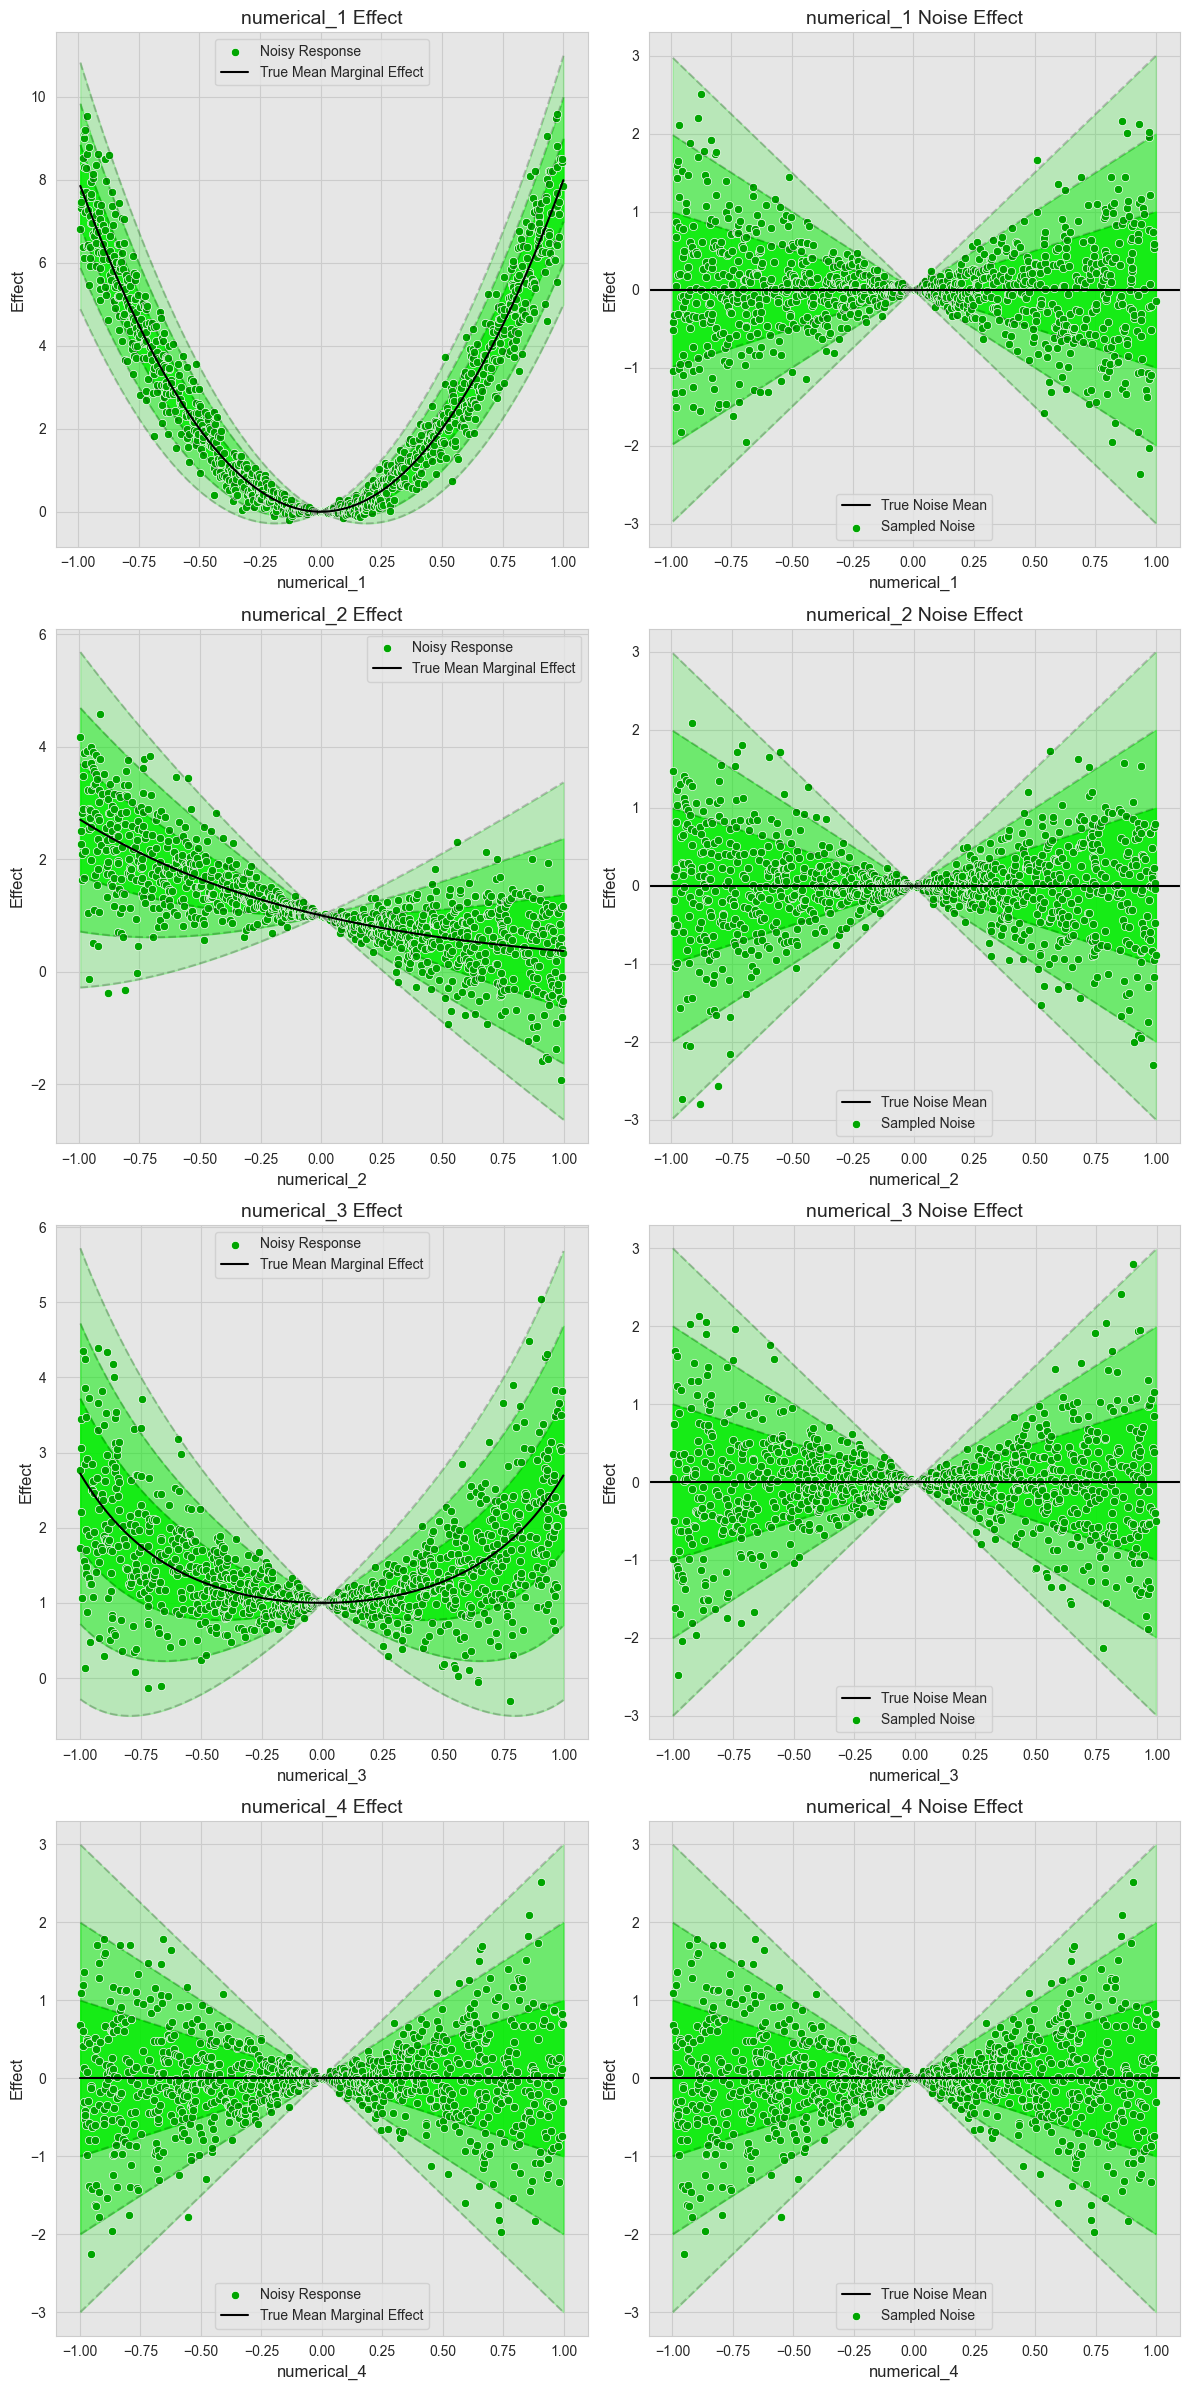

In [7]:
n_samples = 1000
data, true_effects = get_synthetic_data(n_samples=n_samples)

X = data.drop(columns=['Response'])
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.values)
X_test_scaled = scaler_X.transform(X_test.values)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

input_dim = X_train_scaled.shape[1]
plt.show()

# Model training.

In [ ]:
model = BayesianNAM(
    cat_feature_info={},
    num_feature_info={
        feature_name: {
            "input_dim": 1,
            "output_dim": 2
        } for feature_name in X_train.columns
    },
    num_classes=1,
    config=DefaultBayesianNAMConfig(),
    subnetwork_config=DefaultBayesianNNConfig()
)

num_features = {
    feature_name: jnp.array(
        X_test_scaled[:, col_idx]
    ) for col_idx, feature_name in enumerate(X_test.columns)
}
cat_features = {}

In [ ]:
predictions, final_params, submodel_contributions = model.predict(
    num_features=num_features,
    cat_features=cat_features,
)
y_pred = predictions.mean(axis=0)

# Results analysis.

In [ ]:
final_loc = final_params[:, :, 0]
final_scale = final_params[:, :, 1]
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6 * 2))
for i, (final_param_name, final_param_pred) in enumerate(
        zip(
            ["loc", "scale"],
            [final_loc, final_scale]
        )
):
    sns.distplot(
        final_param_pred.flatten(),
        color=GREEN_RGB_COLORS[0],
        ax=ax[i]
    )
    # Mark the mean with a vertical line.
    ax[i].axvline(
        x=final_param_pred.mean(),
        color='black',
        linestyle='dashed',
        linewidth=2,
        label="Mean"
    )
    ax[i].set_title(f"Final Parameter Predictions - {final_param_name.title()}", fontsize=12)
    ax[i].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
interaction_feature_information = {}
all_features = {**num_features, **cat_features}
for interaction_name in submodel_contributions.keys():
    if ":" not in interaction_name:
        continue

    feature_names = interaction_name.split(":")
    interaction_feature_information[interaction_name] = jnp.concatenate(
        [jnp.expand_dims(all_features[name], axis=-1) for name in feature_names],
        axis=-1
    )

In [ ]:
model.plot_posterior_samples()

In [ ]:
plot_feature_contributions(
    num_features=num_features,
    cat_features=cat_features,
    interaction_features=interaction_feature_information,
    submodel_contributions=submodel_contributions
)

In [ ]:
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
sns.scatterplot(
    x=y_test_scaled,
    y=y_pred,
    color=GREEN_RGB_COLORS[0],
    label="Predictions",
    ax=ax
)
ax.set_xlabel("Actuals", fontsize=12)
ax.set_ylabel("Predictions", fontsize=12)
ax.set_title(
    f"Predictions vs. Actuals | "
    f"MSE: {np.mean((y_test_scaled - y_pred) ** 2):.4f}",
    fontsize=12
)
ax.legend(loc='best', fontsize=12, frameon=False)
ax.grid(True)
plt.tight_layout()
plt.show()